SOB-14 100 mM THIOSULFATE BIOTRANSFORMATION

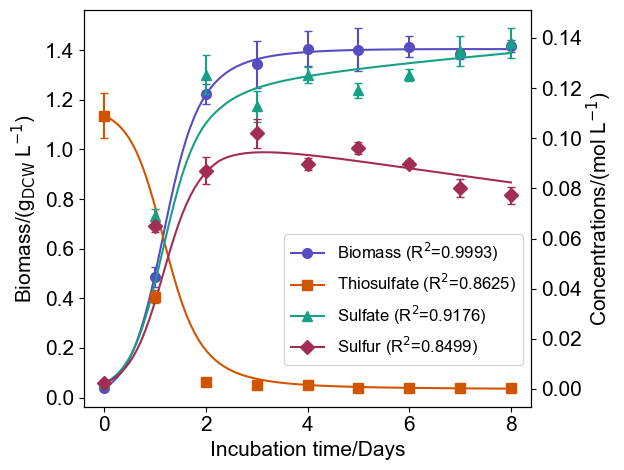

Fitted parameters:
μmax-H = 0.2023 h⁻¹
μmax-true = 0.1221 h⁻¹
Ki = 0.3184 mol/L
Ks = 0.0343 mol/L
k_so = 0.000996 L/g DCW-h
ms = 0.000004 mol S2O3/g DCW-h
Pso4_max = 0.1331 mol SO4/L
S_max_h = 0.1045 M

Fixed parameters: 
Yxs = 12.64 g DCW/mol S2O3 
Yps = 1.11 mol SO4/mol S2O3 
Yp2s = 0.9 mol S/mol S2O3 
Yso4_s0 = 0.7000 mol SO4/mol S
Ks_switch = 0.010000 mol/L 
n = 1.1

R2 values:
Biomass (X): 0.9993, Thiosulfate (S): 0.8625, Sulfate (P_SO4): 0.9176, Sulfur (P_S0): 0.8499

RMSE values:
Biomass (X): 0.0124, Thiosulfate (S): 0.0127, Sulfate (P_SO4): 0.0118, Sulfur (P_S0): 0.0109

At S = 0.010
interpolated X = 1.07050, interpolated PS = 0.08244
sulfur oxidation rate, r_so = 0.00211, Actual sulfate production rate = 0.00148


In [3]:
# ===== MODEL VALIDATION: SOB-14 100 mM THIOSULFATE BIOTRANSFORMATION =====

# -------- Import Libraries --------
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from scipy.stats import sem, t

# ===================== LOAD DATASET =====================
# -------- Triplicate Experimental Data --------
t_data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])  # in Days

X_trip = np.array([
    [0.0402, 0.4731, 1.2095, 1.3865, 1.4322, 1.3619, 1.4315, 1.3919, 1.4069],
    [0.0377, 0.4830, 1.2417, 1.3273, 1.3752, 1.4175, 1.3978, 1.3830, 1.4246],
    [0.0390, 0.5050, 1.2207, 1.3152, 1.4106, 1.4266, 1.4136, 1.3771, 1.4195]
])

S_trip = np.array([
    [0.1067, 0.0377, 0.0028, 0.0017, 0.0016, 0.0005, 0.0005, 0.0005, 0.0005],
    [0.1132, 0.0372, 0.0030, 0.0016, 0.0014, 0.0005, 0.0005, 0.0005, 0.0005],
    [0.1072, 0.0357, 0.0030, 0.0018, 0.0015, 0.0005, 0.0005, 0.0005, 0.0005]
])

P_trip = np.array([
    [0.0022, 0.0703, 0.1219, 0.1157, 0.1241, 0.1190, 0.1243, 0.1345, 0.1390],
    [0.0022, 0.0685, 0.1280, 0.1115, 0.1251, 0.1180, 0.1255, 0.1372, 0.1396],
    [0.0022, 0.0685, 0.1260, 0.1113, 0.1267, 0.1203, 0.1261, 0.1324, 0.1351]
])

PS_trip = np.array([
    [0.0022, 0.0663, 0.0846, 0.1045, 0.0889, 0.0959, 0.0890, 0.0802, 0.0778],
    [0.0022, 0.0645, 0.0889, 0.1007, 0.0895, 0.0951, 0.0898, 0.0818, 0.0782],
    [0.0022, 0.0645, 0.0875, 0.1005, 0.0907, 0.0970, 0.0902, 0.0789, 0.0756]
])

# ===================== UTILITY FUNCTIONS =====================
def mean_ci(data):
    mean = np.mean(data, axis=0)
    ci = sem(data, axis=0) * t.ppf(0.975, df=data.shape[0]-1)
    return mean, ci

def calculate_r2(observed, predicted):
    return 1 - np.sum((observed - predicted) ** 2) / np.sum((observed - np.mean(observed)) ** 2)

def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

# ===================== CALCULATE MEANS & ERROR BARS =====================
X_data, X_err = mean_ci(X_trip)
S_data, S_err = mean_ci(S_trip)
P_data, P_err = mean_ci(P_trip)
PS_data, PS_err = mean_ci(PS_trip)

# ===================== FIXED MODEL PARAMETERS =====================
Yxs = 12.64
Yps = 1.11
Yp2s = 0.9
Yso4_s0 = 0.7
k = 1.1
Ks_switch = 0.010

# ===================== MODEL DEFINITION =====================
def model(y, t, u, Ks, Ki, k_so, Pso4_max, ms):
    X, S, P, Ps = y
    mu = ((u * S) / (Ks + S + ((S**2) / Ki))) * (max(1e-6, 1 - P / Pso4_max) ** k)
    dXdt = mu * X
    r_so = k_so * Ps * X if S < Ks_switch else 0
    dPdt = dXdt * (Yps / Yxs) + Yso4_s0 * r_so
    dP2dt = dXdt * (Yp2s / Yxs) - r_so
    dSdt = - (dXdt / Yxs) - ms * X
    return [dXdt, dSdt, dPdt, dP2dt]

# ===================== PARAMETER FITTING =====================
def objective(t, u, Ks, Ki, k_so, Pso4_max, ms):
    y0 = [X_data[0], S_data[0], P_data[0], PS_data[0]]
    sol = odeint(model, y0, t, args=(u, Ks, Ki, k_so, Pso4_max, ms))
    return sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]

def combined_objective(t, u, Ks, Ki, k_so, Pso4_max, ms):
    X, S, P, Ps = objective(t, u, Ks, Ki, k_so, Pso4_max, ms)
    return np.concatenate((X, S, P, Ps))

# -------- Combine all experimental data for fitting --------
data = np.concatenate((X_data, S_data, P_data, PS_data))
initial_guess = [0.1, 0.001, 0.01, 0.1, 0.136, 0.0001]
bounds = ([0.001, 0.0001, 0.0001, 0.00001, 0.05, 0.0001], 
          [5, 1, 3, 0.1, 1, 0.00011])

params, _ = curve_fit(combined_objective, t_data, data, p0=initial_guess, bounds=bounds)
u_fitted, Ks_fitted, Ki_fitted, k_so_fitted, Pso4_max_fitted, ms_fitted = params

# ===================== SIMULATE MODEL WITH FITTED PARAMETERS =====================
y0 = [X_data[0], S_data[0], P_data[0], PS_data[0]]
t_fine = np.linspace(0, 8, 100)
solution = odeint(model, y0, t_fine, args=(u_fitted, Ks_fitted, Ki_fitted, k_so_fitted, Pso4_max_fitted, ms_fitted))
X_fit, S_fit, P_fit, PS_fit = solution.T

# ===================== INTERPOLATION & METRICS =====================
X_pred = np.interp(t_data, t_fine, X_fit)
S_pred = np.interp(t_data, t_fine, S_fit)
P_pred = np.interp(t_data, t_fine, P_fit)
PS_pred = np.interp(t_data, t_fine, PS_fit)

r2_X = calculate_r2(X_data, X_pred)
r2_S = calculate_r2(S_data, S_pred)
r2_P = calculate_r2(P_data, P_pred)
r2_P2 = calculate_r2(PS_data, PS_pred)

rmse_X = calculate_rmse(X_data, X_pred)
rmse_S = calculate_rmse(S_data, S_pred)
rmse_P = calculate_rmse(P_data, P_pred)
rmse_P2 = calculate_rmse(PS_data, PS_pred)

# ===================== PLOTTING: MODEL FIT VS DATA =====================
colors = ['#574dc0', '#d35400', '#16a085', '#a12d54']
plt.rcParams['font.family'] = 'Arial'

fig, ax1 = plt.subplots()
marker_size = 7  # Adjust marker size here

# --- Biomass (primary y-axis) ---
ax1.plot(t_fine, X_fit, '-', color=colors[0])
ax1.errorbar(t_data, X_data, yerr=X_err, fmt='o',
             markerfacecolor=colors[0], markeredgecolor=colors[0],
             ecolor=colors[0], capsize=3, markersize=marker_size)
ax1.set_xlabel('Incubation time/Days', fontsize=15)
ax1.set_ylabel(r'Biomass/(g$_{\mathrm{DCW}}$ L$^{-1}$)', fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

# --- S, P, PS (secondary y-axis) ---
ax2 = ax1.twinx()
ax2.plot(t_fine, S_fit, '-', color=colors[1])
ax2.errorbar(t_data, S_data, yerr=S_err, fmt='s',
             markerfacecolor=colors[1], markeredgecolor=colors[1],
             ecolor=colors[1], capsize=3, markersize=marker_size)
ax2.plot(t_fine, P_fit, '-', color=colors[2])
ax2.errorbar(t_data, P_data, yerr=P_err, fmt='^',
             markerfacecolor=colors[2], markeredgecolor=colors[2],
             ecolor=colors[2], capsize=3, markersize=marker_size)
ax2.plot(t_fine, PS_fit, '-', color=colors[3])
ax2.errorbar(t_data, PS_data, yerr=PS_err, fmt='D',
             markerfacecolor=colors[3], markeredgecolor=colors[3],
             ecolor=colors[3], capsize=3, markersize=marker_size)

ax2.set_ylabel(r'Concentrations/(mol L$^{-1}$)', color='k', fontsize=15)
ax2.tick_params(axis='y', labelcolor='k', labelsize=15)
ax2.yaxis.set_label_coords(1.12, 0.5)

legend_marker_size = 7
legend_elements = [
    Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label=f'Biomass (R$^2$={r2_X:.4f})',
           markerfacecolor=colors[0], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[1], marker='s', linestyle='-', label=f'Thiosulfate (R$^2$={r2_S:.4f})',
           markerfacecolor=colors[1], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[2], marker='^', linestyle='-', label=f'Sulfate (R$^2$={r2_P:.4f})',
           markerfacecolor=colors[2], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[3], marker='D', linestyle='-', label=f'Sulfur (R$^2$={r2_P2:.4f})',
           markerfacecolor=colors[3], markersize=legend_marker_size)
]

fig.tight_layout()
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1, 0.27),
           bbox_transform=ax1.transAxes, fontsize=12)

plt.show()

# ===================== DERIVED HALDANE METRICS & TARGET S INTERPOLATION =====================
umax_true = u_fitted / (1 + 2 * (Ks_fitted / Ki_fitted)**0.5)
S_max_h = (Ks_fitted * Ki_fitted)**0.5

print(f"Fitted parameters:")
print(f"μmax-H = {u_fitted/24:.4f} h⁻¹")
print(f"μmax-true = {umax_true/24:.4f} h⁻¹")
print(f"Ki = {Ki_fitted:.4f} mol/L")
print(f"Ks = {Ks_fitted:.4f} mol/L")
print(f"k_so = {k_so_fitted/24:.6f} L/g DCW-h")
print(f"ms = {ms_fitted/24:.6f} mol S2O3/g DCW-h")
print(f"Pso4_max = {Pso4_max_fitted:.4f} mol SO4/L")
print(f"S_max_h = {S_max_h:.4f} M")

print(f"\nFixed parameters: \nYxs = {Yxs} g DCW/mol S2O3 \nYps = {Yps} mol SO4/mol S2O3 \nYp2s = {Yp2s} mol S/mol S2O3 \nYso4_s0 = {Yso4_s0:.4f} mol SO4/mol S")
print(f"Ks_switch = {Ks_switch:.6f} mol/L \nn = {k}")

print(f"\nR2 values:")
print(f"Biomass (X): {r2_X:.4f}, Thiosulfate (S): {r2_S:.4f}, Sulfate (P_SO4): {r2_P:.4f}, Sulfur (P_S0): {r2_P2:.4f}")

print(f"\nRMSE values:")
print(f"Biomass (X): {rmse_X:.4f}, Thiosulfate (S): {rmse_S:.4f}, Sulfate (P_SO4): {rmse_P:.4f}, Sulfur (P_S0): {rmse_P2:.4f}\n")

# --------- Interpolate X and PS at a target S (Ks_switch) ---------
target_S = Ks_switch
sort_idx = np.argsort(S_data)
S_sorted = S_data[sort_idx]
X_sorted = X_data[sort_idx]
PS_sorted = PS_data[sort_idx]

X_at_S_target = np.interp(target_S, S_sorted, X_sorted)
PS_at_S_target = np.interp(target_S, S_sorted, PS_sorted)

# --------- Sulfur oxidation rate at S = Ks_switch ---------
r_so_target = k_so_fitted * PS_at_S_target * X_at_S_target
r_so_so4 = r_so_target * Yso4_s0

print(f"At S = {target_S:.3f}")
print(f"interpolated X = {X_at_S_target:.5f}, interpolated PS = {PS_at_S_target:.5f}")
print(f"sulfur oxidation rate, r_so = {r_so_target:.5f}, Actual sulfate production rate ={r_so_so4: .5f}")


